In [1]:
#Install gdown library 
!pip install gdown


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#Download file in Jupyter notebook
import gdown

file_id = "1QrwKAn4UmmJ0KKVBj-C6G4Gh64GOPB1m"
url = f"https://drive.google.com/uc?id={file_id}"

output = 'PaySim Synthetic Financial Data.csv'  # Specify your desired output file name
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QrwKAn4UmmJ0KKVBj-C6G4Gh64GOPB1m
To: /Users/jasminemoniquecooper/PaySim Synthetic Financial Data.csv
100%|██████████████████████████████████████| 78.0M/78.0M [00:06<00:00, 11.6MB/s]


'PaySim Synthetic Financial Data.csv'

In [3]:
#Load the CSV file into a DataFrame 

import pandas as pd
paysimfin_data = pd.read_csv(output)

pd.set_option('display.max_columns', None)
paysimfin_data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
999994,45,PAYMENT,2987.49,C2072426611,579096.28,576108.80,M58668896,0.0,0.0,0,0
999995,45,PAYMENT,10913.42,C1384914558,576108.80,565195.38,M166797080,0.0,0.0,0,0
999996,45,PAYMENT,2014.46,C1207593845,565195.38,563180.92,M1027899613,0.0,0.0,0,0
999997,45,PAYMENT,18839.45,C260638437,563180.92,544341.47,M243388883,0.0,0.0,0,0


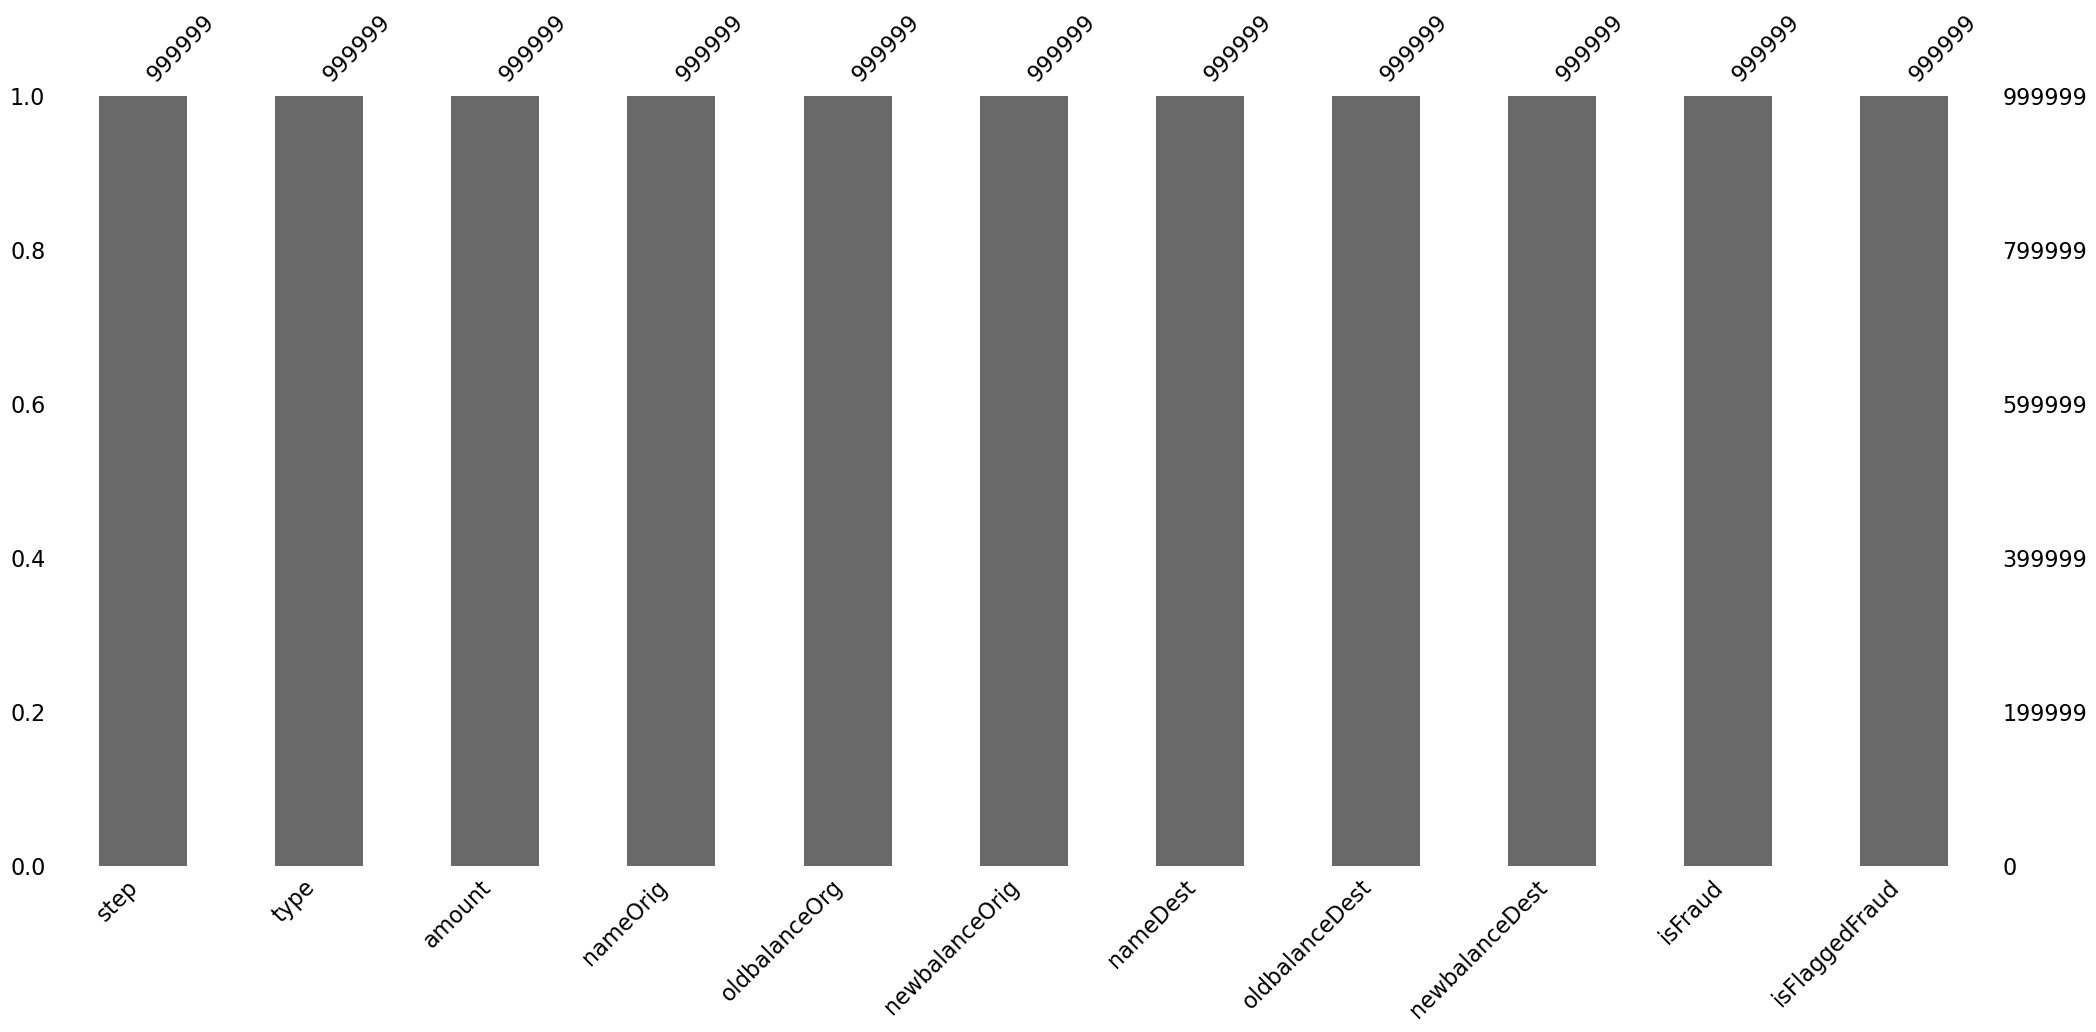

In [4]:
#Check for missing values 

import missingno as msno
import matplotlib.pyplot as plt
column_order = paysimfin_data.isnull().sum().sort_values().index
msno.bar(paysimfin_data[column_order])
plt.show()

In [5]:
print(paysimfin_data.describe())

                step        amount  oldbalanceOrg  newbalanceOrig  \
count  999999.000000  9.999990e+05   9.999990e+05    9.999990e+05   
mean       25.156367  1.602501e+05   8.776706e+05    8.983469e+05   
std        12.652091  2.592585e+05   2.982421e+06    3.019327e+06   
min         1.000000  1.000000e-01   0.000000e+00    0.000000e+00   
25%        14.000000  1.275992e+04   0.000000e+00    0.000000e+00   
50%        20.000000  7.953726e+04   1.595700e+04    0.000000e+00   
75%        38.000000  2.166063e+05   1.397503e+05    1.797897e+05   
max        45.000000  1.000000e+07   3.893942e+07    3.894623e+07   

       oldbalanceDest  newbalanceDest        isFraud  isFlaggedFraud  
count    9.999990e+05    9.999990e+05  999999.000000        999999.0  
mean     9.860678e+05    1.125663e+06       0.000535             0.0  
std      2.305424e+06    2.426588e+06       0.023124             0.0  
min      0.000000e+00    0.000000e+00       0.000000             0.0  
25%      0.000000e+00  

In [6]:
paysimfin_data['isFlaggedFraud'].value_counts()

0    999999
Name: isFlaggedFraud, dtype: int64

In [7]:
paysimfin_data['isFraud'].value_counts()

0    999464
1       535
Name: isFraud, dtype: int64

In [8]:
#Dropping 'isFlaggedFraud' and 'isFraud' columns
#Prelabled columns and data should be analyzed without labels 
#Dropping 'nameOrig' and 'nameDest'since they are unique identifiers and not essential for anomaly detection

columns_to_drop = ['isFlaggedFraud', 'isFraud', 'nameOrig', 'nameDest']
paysim_data_new = paysimfin_data.drop(columns=columns_to_drop)
print(paysim_data_new.head())

   step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0   
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0   
2     1  TRANSFER    181.00          181.0            0.00             0.0   
3     1  CASH_OUT    181.00          181.0            0.00         21182.0   
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  


In [9]:
#Verify if column is categorical 
print(paysim_data_new['type'].unique()) 

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


In [10]:
#Convert categorical column to numeric for analysis 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
paysim_data_new['type'] = encoder.fit_transform(paysim_data_new['type'])

In [11]:
#Apply Isolation Forest for fraud detection - unsupervised anomaly detection 
#Use the anomalies (fraud flagged) as target labels 
#Train XGBoost models on the features and labeled data (anomalies)
#Perform hyperparameter tuning 
#Evaluate model performance 

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
import random

np.random.seed(42)
random.seed(42)


X= paysim_data_new

iso_forest = IsolationForest(
    n_estimators=150,
    max_samples=0.8,
    contamination=0.2,
    random_state=42
)
iso_forest.fit(X)  # Fit the model on the feature matrix

# Get anomaly predictions
iso_predictions = iso_forest.predict(X)

# Convert -1 (anomalous) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_predictions = np.where(iso_predictions == 1, 0, 1)

#Add the Flagged Anomalies as a Target Label
y = iso_predictions  # Fraud labels (target variable)

#Train a Supervised Model (XGBoost)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=10,  # Tuning for class imbalance
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)

# Train the model
xgb_model.fit(X_train, y_train)

# Get predictions
y_pred = xgb_model.predict(X_test)

# Evaluate performance
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc:.2f}")

#Hyperparameter Tuning


param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'scale_pos_weight': [1, 5, 10]  # Tuning for class imbalance
}

grid_search = RandomizedSearchCV(xgb.XGBClassifier(), param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=42)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)
print(classification_report(y_test, y_pred_tuned))

# Print the predictions
print("Predictions after hyperparameter tuning:")
print(y_pred_tuned)

# After hyperparameter tuning, re-evaluate AUC
tuned_auc = roc_auc_score(y_test, y_pred_tuned)
print(f"Tuned AUC: {tuned_auc:.2f}")

/Users/jasminemoniquecooper/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.96      0.98    159943
           1       0.86      0.99      0.92     40057

    accuracy                           0.97    200000
   macro avg       0.93      0.98      0.95    200000
weighted avg       0.97      0.97      0.97    200000

AUC: 0.98
Best Parameters: {'scale_pos_weight': 5, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    159943
           1       0.94      0.99      0.97     40057

    accuracy                           0.99    200000
   macro avg       0.97      0.99      0.98    200000
weighted avg       0.99      0.99      0.99    200000

Predictions after hyperparameter tuning:
[1 0 1 ... 0 0 0]
Tuned AUC: 0.99


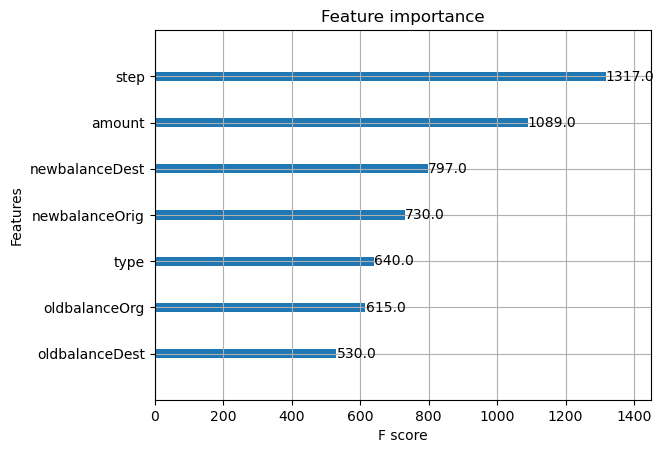

In [12]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.show()


In [13]:
pip install shap



[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


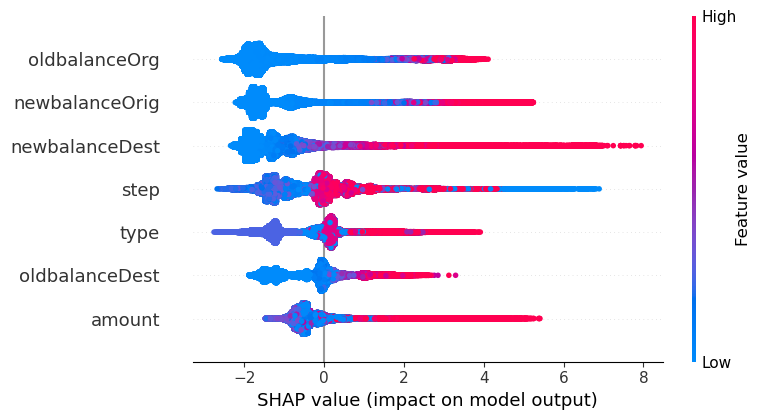

In [14]:
import shap

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_model)

# Get SHAP values for the test data
shap_values = explainer(X_test)

# Plot a summary of SHAP values
shap.summary_plot(shap_values, X_test)


In [15]:
# Get the indices of the test set
test_indices = X_test.index

# Add predictions as a new column to the test set
paysimfin_data['y_pred_tuned'] = np.nan  # Initialize with NaN for all rows
paysimfin_data.loc[test_indices, 'y_pred_tuned'] = y_pred  # Assign predictions to the test set rows

# Now `paysim_data` will have the predictions added only for the rows in the test set
print(paysimfin_data.head()) 


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   y_pred_tuned  
0           1.0  
1           NaN  
2           NaN  
3           NaN  
4       

In [16]:
#Export dataframe to CSV file 

import os

# Get the path to the Downloads folder
downloads_folder = os.path.expanduser('/Users/jasminemoniquecooper/Downloads')

# Specify the file name and path
file_path = os.path.join(downloads_folder, 'paysimfin_data_predictions.csv')

# Assuming you want to export paysimfin_data with the predictions
paysimfin_data.to_csv(file_path, index=False)  # Export the DataFrame to CSV

print(f"File saved to: {file_path}")



File saved to: /Users/jasminemoniquecooper/Downloads/paysimfin_data_predictions.csv
